In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 101 kB 7.9 MB/s 
     |████████████████████████████████| 596 kB 56.5 MB/s 
     |████████████████████████████████| 6.6 MB 29.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip3 install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 5.0 MB/s 


## Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data import get_tokenizer
from torch.utils.data.dataset import random_split
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torchmetrics import F1Score

## Loading the data

In [ ]:
df = pd.read_csv('quora_duplicate_questions.tsv', sep = '\t')

## Removing Null records

In [ ]:
df = df.dropna(how='any',axis=0) 

## Finding the token frequency

In [ ]:

#que_df = df[["question1"]]
que_df = pd.concat((df['question1'], df['question2']),axis =0,ignore_index=True)
#que_df["question1"] = df[["question2"]]
que_df.columns = ['Questions']

In [ ]:
que_df

0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor (Koh-i-Noor) Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely? How can I solve...
4         Which one dissolve in water quikly sugar, salt...
                                ...                        
808569    How many keywords are there in PERL Programmin...
808570           Is it true that there is life after death?
808571                                    What's this coin?
808572    I am having little hairfall problem but I want...
808573        What is it like to have sex with your cousin?
Length: 808574, dtype: object

In [ ]:
num_words = que_df.apply(lambda row: len(row.split(" ")))



AxesSubplot(0.125,0.125;0.775x0.755)


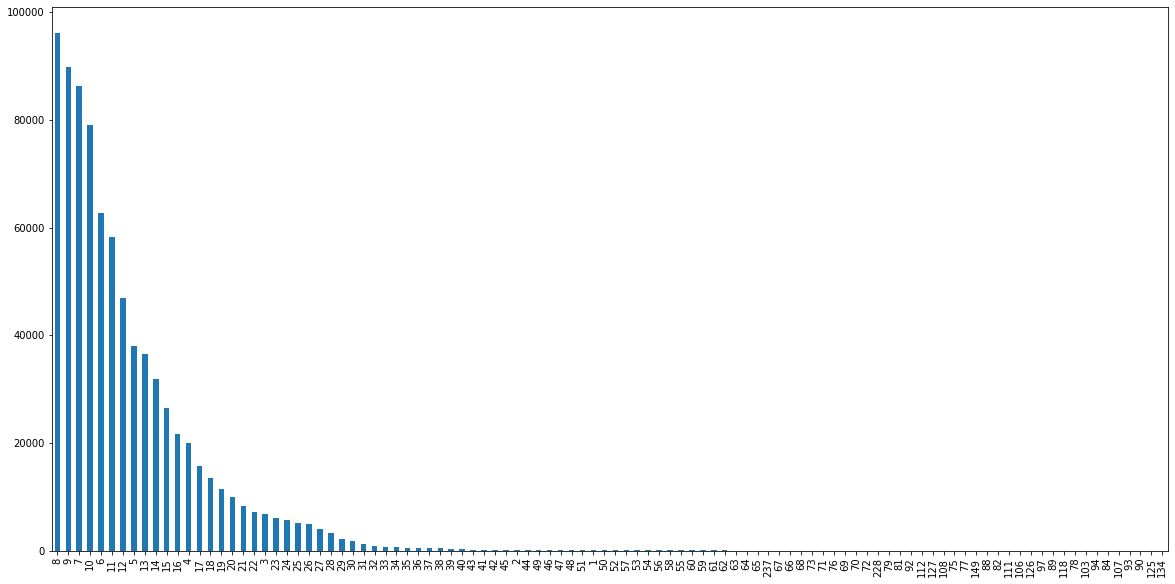

In [ ]:
print(num_words.value_counts().plot(kind="bar", figsize = (20,10)))

In [ ]:
class Preprocessing:
	
    def __init__(self):
		    self.data = 'quora_duplicate_questions.tsv'
		    self.max_len = 60
		    self.max_words = 6000
		    self.test_size = 0.2
		    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
		
    def load_data(self):
		    df = pd.read_csv(self.data, sep ='\t')
		    df.drop(['id','qid1','qid2'], axis=1, inplace=True)
		    df = df.dropna()
		    X = df[['question1','question2']]
		    Y = df['is_duplicate']
		    #print(df)
		    #lens = [int(len(df)*0.8), int(len(df)*0.2)]
		    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,Y, random_state = 123, test_size=0.2)

    def sequence_to_token(self):
		    #print(list(self.X_train['question1']))
		    question_1_train = self.tokenizer(list(self.X_train['question1']), padding='max_length', truncation=True, max_length=self.max_len)
		    question_2_train = self.tokenizer(list(self.X_train['question2']), padding='max_length', truncation=True, max_length= self.max_len)
		    question_1_test = self.tokenizer(list(self.X_test['question1']), padding='max_length', truncation=True, max_length=self.max_len)
		    question_2_test = self.tokenizer(list(self.X_test['question2']), padding='max_length', truncation=True, max_length= self.max_len)
		    return question_1_train['input_ids'] , question_2_train['input_ids'], question_1_test['input_ids'] , question_2_test['input_ids']

In [ ]:
pro = Preprocessing()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
pro.load_data()

In [ ]:
pro.X_train

,question1,question2
270278,What are the factors affecting rates of us dol...,How can I get the cheapest flight from Brazil ...
381357,Do you have friends with benefits?,Should I do friends with benefits or not?
379776,What is the best résumé font?,What are some good fonts?
54070,How can I smartly cut myself?,Can someone who thinks about suicide for 7 yea...
46450,How do I see who is viewing my Instagram videos?,Can one tell who viewed my Instagram videos?
...,...,...
192477,What happens if a lightning strikes in the ocean?,What happens when lightning strikes the oceans...
17730,How can dogs understand human language?,Can dogs understand the human language?
28030,What's your favourite lotion?,What's your favourite skin lotion?
277871,How is SRCC's GBO programme?,"Which of these college is better for MBA, SRCC..."


In [ ]:
question_1_train, question_2_train, question_1_test, question_2_test = pro.sequence_to_token()

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        nn.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        out = nn.sigmoid(out)
        return out
 

In [ ]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 120 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [ ]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers,120) #our lstm class
       

In [ ]:
pro.y_train

270278    0
381357    0
379776    0
54070     0
46450     1
         ..
192477    1
17730     0
28030     1
277871    0
249344    0
Name: is_duplicate, Length: 323429, dtype: int64

In [ ]:
Question1_train_tensors = Variable(torch.Tensor(question_1_train))
Question1_test_tensors = Variable(torch.Tensor(question_1_test))
Question2_train_tensors = Variable(torch.Tensor(question_2_train))
Question2_test_tensors = Variable(torch.Tensor(question_2_test))

y_train_tensors = Variable(torch.Tensor(pro.y_train.values))
y_test_tensors = Variable(torch.Tensor(pro.y_test.values)) 

In [ ]:
Question1_train_final = torch.reshape(Question1_train_tensors,   (Question1_train_tensors.shape[0], 1, Question1_train_tensors.shape[1]))
Question2_train_final = torch.reshape(Question2_train_tensors,   (Question2_train_tensors.shape[0], 1, Question2_train_tensors.shape[1]))
Question1_test_final = torch.reshape(Question1_test_tensors,  (Question1_test_tensors.shape[0], 1, Question1_test_tensors.shape[1])) 
Question2_test_final = torch.reshape(Question2_test_tensors,  (Question2_test_tensors.shape[0], 1, Question2_test_tensors.shape[1])) 

In [ ]:
criterion = nn.BCELoss()    # Binary classification loss
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [ ]:
Question1_train_final.size()

torch.Size([323429, 1, 60])

In [ ]:
Question2_train_final.size()

torch.Size([323429, 1, 60])

## Concatenate the tensors

In [ ]:
X_train_tensors = torch.cat((Question1_train_final,Question2_train_final),2)

In [ ]:
X_test_tensors = torch.cat((Question1_test_final,Question2_test_final),2)

In [ ]:
X_train_tensors

tensor([[[ 101., 2054., 2024.,  ...,    0.,    0.,    0.]],

        [[ 101., 2079., 2017.,  ...,    0.,    0.,    0.]],

        [[ 101., 2054., 2003.,  ...,    0.,    0.,    0.]],

        ...,

        [[ 101., 2054., 1005.,  ...,    0.,    0.,    0.]],

        [[ 101., 2129., 2003.,  ...,    0.,    0.,    0.]],

        [[ 101., 2054., 2003.,  ...,    0.,    0.,    0.]]])

In [ ]:
X_train_tensors.size()

torch.Size([323429, 1, 120])

In [ ]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_test_tensors) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  threshold = torch.tensor([0.5]) # setting threshold

  # results = (outputs>threshold).float()*1

  # obtain the loss function
  loss = criterion(torch.squeeze(outputs), y_test_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 10 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 


Epoch: 0, loss: 0.68018
Epoch: 10, loss: 0.66183
Epoch: 20, loss: 0.65836
Epoch: 30, loss: 0.65870
Epoch: 40, loss: 0.65803
Epoch: 50, loss: 0.65772
Epoch: 60, loss: 0.65755
Epoch: 70, loss: 0.65738
Epoch: 80, loss: 0.65713
Epoch: 90, loss: 0.65676
Epoch: 100, loss: 0.65664
Epoch: 110, loss: 0.65650
Epoch: 120, loss: 0.65642
Epoch: 130, loss: 0.65633
Epoch: 140, loss: 0.65619
Epoch: 150, loss: 0.65608
Epoch: 160, loss: 0.65601
Epoch: 170, loss: 0.65592
Epoch: 180, loss: 0.65581
Epoch: 190, loss: 0.65561
Epoch: 200, loss: 0.65525
Epoch: 210, loss: 0.65502
Epoch: 220, loss: 0.65484
Epoch: 230, loss: 0.65457
Epoch: 240, loss: 0.65416
Epoch: 250, loss: 0.65364
Epoch: 260, loss: 0.65326
Epoch: 270, loss: 0.65268
Epoch: 280, loss: 0.65214
Epoch: 290, loss: 0.65170
Epoch: 300, loss: 0.65121
Epoch: 310, loss: 0.65082
Epoch: 320, loss: 0.65041
Epoch: 330, loss: 0.65033
Epoch: 340, loss: 0.65017
Epoch: 350, loss: 0.65008
Epoch: 360, loss: 0.64983
Epoch: 370, loss: 0.64974
Epoch: 380, loss: 0.649

In [ ]:
outputs

tensor([[0.4662],
        [0.3098],
        [0.3098],
        ...,
        [0.4662],
        [0.4662],
        [0.3098]], grad_fn=<SigmoidBackward0>)

In [ ]:
threshold = torch.tensor([0.5])
results = (outputs>threshold).float()*1
f1 = F1Score(num_classes=2)
f1(torch.squeeze(results).type(torch.int), y_test_tensors.type(torch.int))


tensor(0.6292)

In [ ]:
y_train_tensors.type(torch.int)

tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.int32)

In [ ]:
torch.squeeze(results)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [ ]:
y_train_tensors.type(torch.int) 

tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.int32)

In [ ]:
lstm1

LSTM1(
  (lstm): LSTM(120, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
[1] +[2]

[1, 2]